In [1]:
import pertpy as pt
import scanpy as sc

import random
import numpy as np
import torch
import os
import sklearn
import scipy
from sklearn.neighbors import NearestNeighbors

def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWar

In [2]:
def mixscape(adata,obs_label, ref_label, expr_label, nn=20, return_te = True):
    sc.pp.pca(adata)
    X_pca1 = adata.obsm['X_pca'][adata.obs[obs_label]==expr_label,:]
    X_pca2 = adata.obsm['X_pca'][adata.obs[obs_label]==ref_label,:]
    nbrs = NearestNeighbors(n_neighbors=nn, algorithm='ball_tree').fit(X_pca1)
    mixscape_pca = adata.obsm['X_pca'].copy()
    mixscapematrix = nbrs.kneighbors_graph(X_pca2).toarray()
    mixscape_pca[adata.obs[obs_label]==ref_label,:] = np.dot(mixscapematrix, mixscape_pca[adata.obs[obs_label]==expr_label,:])/20
    if return_te:
        te2 = adata.X[adata.obs[obs_label]==ref_label,:] - (mixscapematrix/np.sum(mixscapematrix,axis=1)[:,None]) @ (adata.X[adata.obs[obs_label]==expr_label,:])
        return mixscape_pca, mixscapematrix, te2
    else:
        return mixscape_pca, mixscapematrix

def run_mixscape(adata, condition_key, cell_type_key, exp_label, ref_label, dataset_name):
    if isinstance(adata.X, scipy.sparse.spmatrix):
        adata.X = adata.X.toarray()

    print(adata)
    if adata.shape[1]>2000:
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var["highly_variable"]]
    
    adata_=adata.copy()
    
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)
    '''
    ms = pt.tl.Mixscape()

    ms.perturbation_signature(
        adata_,
        pert_key=condition_key,
        control=ref_label,
        split_by=None,
        n_neighbors=20,
    )
    '''
    mixscape_pca, mixscapematrix=mixscape(adata=adata,obs_label=condition_key, ref_label=ref_label, expr_label=exp_label, nn=20, return_te = False)

    adata_.obsm["ef"] = np.array(mixscape_pca)#(adata_.layers["X_pert"])
    sc.pp.neighbors(adata_, use_rep="ef")

    sc.tl.umap(adata_, random_state=1)
    sc.pl.umap(adata_, color=[condition_key, cell_type_key], wspace=0.5)

    adata_.write("./mixscape/"+dataset_name+".h5ad")
    
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    import rpy2.robjects as robjects
    import os
    os.environ["R_HOME"]="/home/xx244/.conda/envs/benchmark/lib/R"
    import anndata2ri
    anndata2ri.activate()

    from metrics import calculate_metrics

    try:
        import warnings
        warnings.filterwarnings("ignore")
        warnings.filterwarnings("ignore", category=FutureWarning)
        calculate_metrics(adata_, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='ef', savepath="./mixscape/"+dataset_name+".csv")
    except:
        import warnings
        warnings.filterwarnings("ignore")
        warnings.filterwarnings("ignore", category=FutureWarning)
        calculate_metrics(adata_, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='ef', savepath="./mixscape/"+dataset_name+".csv")

# PBMC

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583

https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'


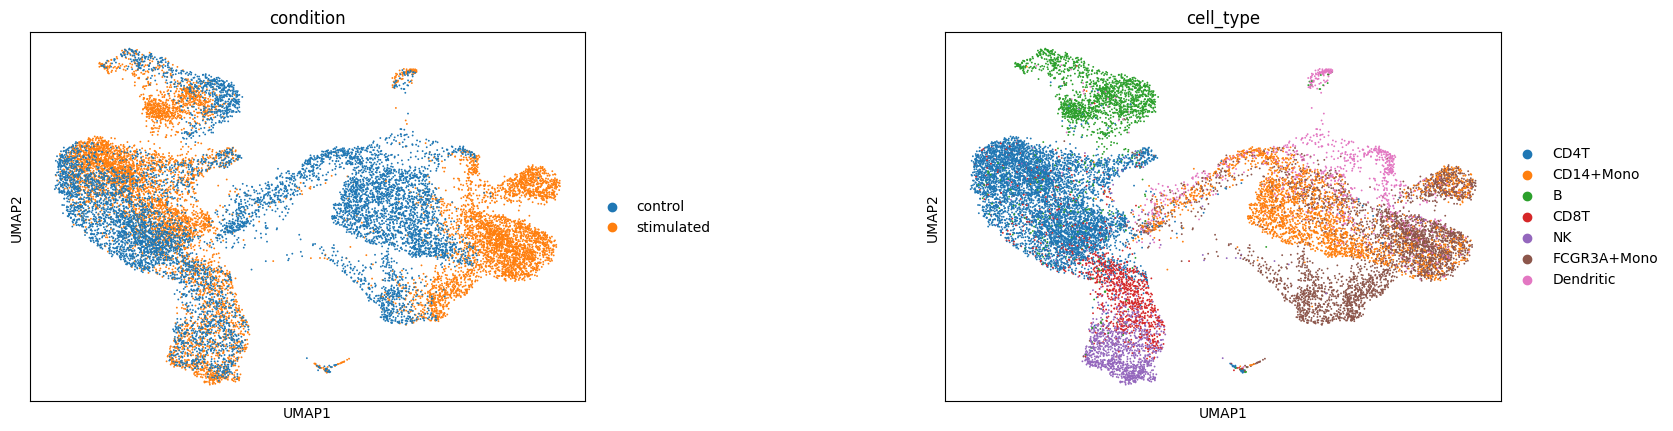

Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.


R_HOME is already set to: /home/xx244/.conda/envs/benchmark/lib/R


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


LISI---


cLISI, bLISI, LISI_F1 0.9320431211669962 0.1719226492780893 0.2902976286444924


ASW---


asw_label 0.5368223376572132


asw_batch 0.6872937408199474


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


Adding diffusion to step 4
Adding diffusion to step 5


kbet_score 0.1276640922346267
graph_conn 0.9663653729673687


NMI, ARI ---
NMI 0.64142886019176
ARI 0.5756369869285456
positive and true positive rate---


    ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
ef   0.536822  0.575637  0.641429  0.932043  0.171923   0.687294   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
ef          0.127664            0.966365   0.646646  0.820991       0.087077   

     F1 LISI  
ef  0.290298  


In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

adata = sc.read_h5ad('../data/PBMC.h5ad')
run_mixscape(adata=adata, condition_key='condition', cell_type_key='cell_type', exp_label='stimulated', ref_label='control', dataset_name="PBMC")

# PBMC (yale)

https://datadryad.org/stash/dataset/doi:10.5061/dryad.4xgxd25g1

AnnData object with n_obs × n_vars = 5027 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


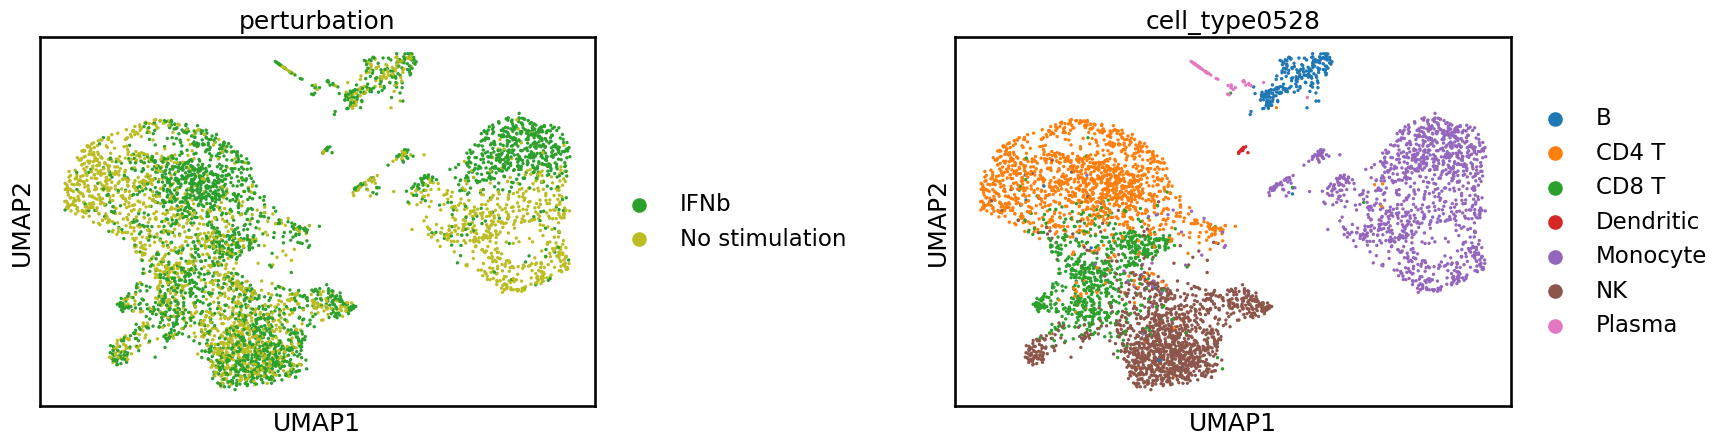

LISI---


cLISI, bLISI, LISI_F1 0.9659990397846461 0.24232264065995607 0.38745218592695674


ASW---


asw_label 0.5704668611288071
asw_batch 0.6695380378074588


kBET---
0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


kbet_score 0.6144081759857484
graph_conn 0.9952719214795114


NMI, ARI ---
NMI 0.7609381260818235
ARI 0.787141623933192
positive and true positive rate---


    ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
ef   0.570467  0.787142  0.760938  0.965999  0.242323   0.669538   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
ef          0.614408            0.995272    0.56441  0.921424       0.187985   

     F1 LISI  
ef  0.387452  


In [4]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

adata = sc.read_h5ad('../data/PBMC_yale_preprocessed.h5ad')
run_mixscape(adata=adata, condition_key='perturbation', cell_type_key='cell_type0528', exp_label='IFNb', ref_label='No stimulation', dataset_name="PBMC_yale")

# The Rhinovirus infection dataset

https://datadryad.org/stash/dataset/doi:10.5061/dryad.4xgxd25g1

AnnData object with n_obs × n_vars = 12255 × 3608
    obs: 'batch', 'leiden', 'cell_type1021', 'condition'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type1021_colors', 'cell_type1021_sizes', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


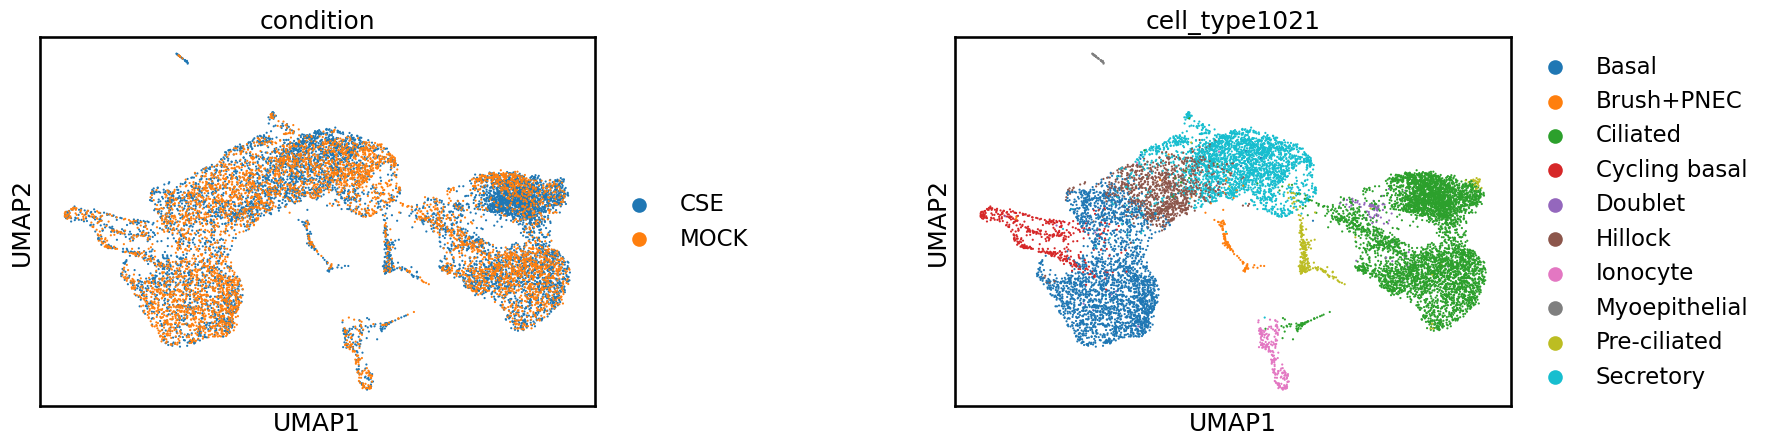

LISI---


cLISI, bLISI, LISI_F1 0.9836065483910553 0.16357891500355828 0.2805078988712005


ASW---


asw_label 0.5450393222272396


asw_batch 0.7730730457648567


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


kbet_score 0.37001179927238925
graph_conn 0.9909630183766682


NMI, ARI ---
NMI 0.7437870211117935
ARI 0.7377692313092996
positive and true positive rate---


    ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
ef   0.545039  0.737769  0.743787  0.983607  0.163579   0.773073   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
ef          0.370012            0.990963   0.223562  0.932681       0.107222   

     F1 LISI  
ef  0.280508  


In [5]:
adata=sc.read_h5ad("../data/rvcse_221021.h5ad")
adata=adata[adata.obs["batch"].isin(['CSE',"MOCK"])].copy()
adata.obs["condition"]=adata.obs["batch"].copy()
run_mixscape(adata=adata, condition_key='condition', cell_type_key="cell_type1021", exp_label='CSE', ref_label='MOCK', dataset_name="virus")

# (EC)CITE-seq

https://www.nature.com/articles/s41588-021-00778-2

AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'n_genes'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'HTO_classification_colors', 'MULTI_ID_colors', 'Phase_colors', 'gene_target_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'replicate_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


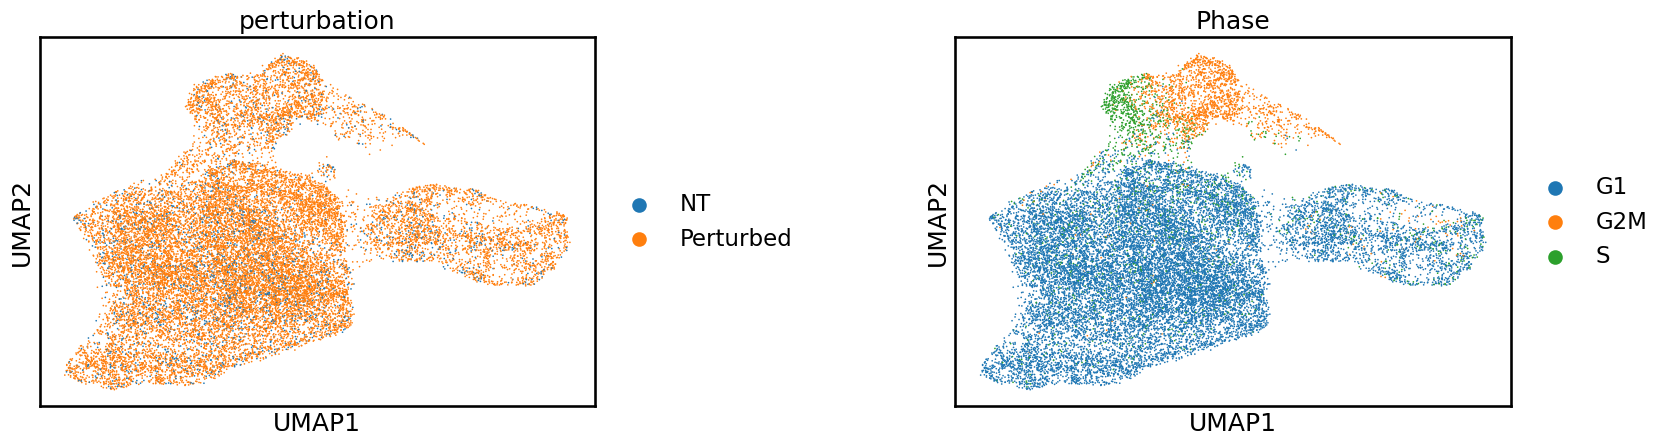

LISI---


cLISI, bLISI, LISI_F1 0.9303678667121824 0.004172775472585476 0.00830828760025338


ASW---


asw_label 0.5404213964939117


asw_batch 0.7207280247517539


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4
Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 7


Adding diffusion to step 8


Adding diffusion to step 9


Adding diffusion to step 10


Adding diffusion to step 11


Adding diffusion to step 12


Adding diffusion to step 13


kbet_score 0.9340287854871676
graph_conn 0.9039317535449441


NMI, ARI ---
NMI 0.4153943462202346
ARI 0.47638369351471505
positive and true positive rate---


    ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
ef   0.540421  0.476384  0.415394  0.930368  0.004173   0.720728   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
ef          0.934029            0.903932   0.336843  0.933089       0.170003   

     F1 LISI  
ef  0.008308  


In [6]:
adata=sc.read_h5ad("../data/ECCITE.h5ad")
run_mixscape(adata=adata, condition_key='perturbation', cell_type_key="Phase", exp_label='NT', ref_label='Perturbed', dataset_name="ECCITE")

# ASD

https://singlecell.broadinstitute.org/single_cell/study/SCP1184/in-vivo-perturb-seq-reveals-neuronal-and-glial-abnormalities-associated-with-asd-risk-genes#study-download

AnnData object with n_obs × n_vars = 49067 × 2000
    obs: 'nGene', 'nUMI', 'Cluster', 'Batch', 'CellType', 'Perturbation', 'isKey', 'isAnalysed', 'SCRUBLET', 'perturb01'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch_colors', 'CellType_colors', 'Perturbation_colors', 'hvg', 'neighbors', 'pca', 'perturb01_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


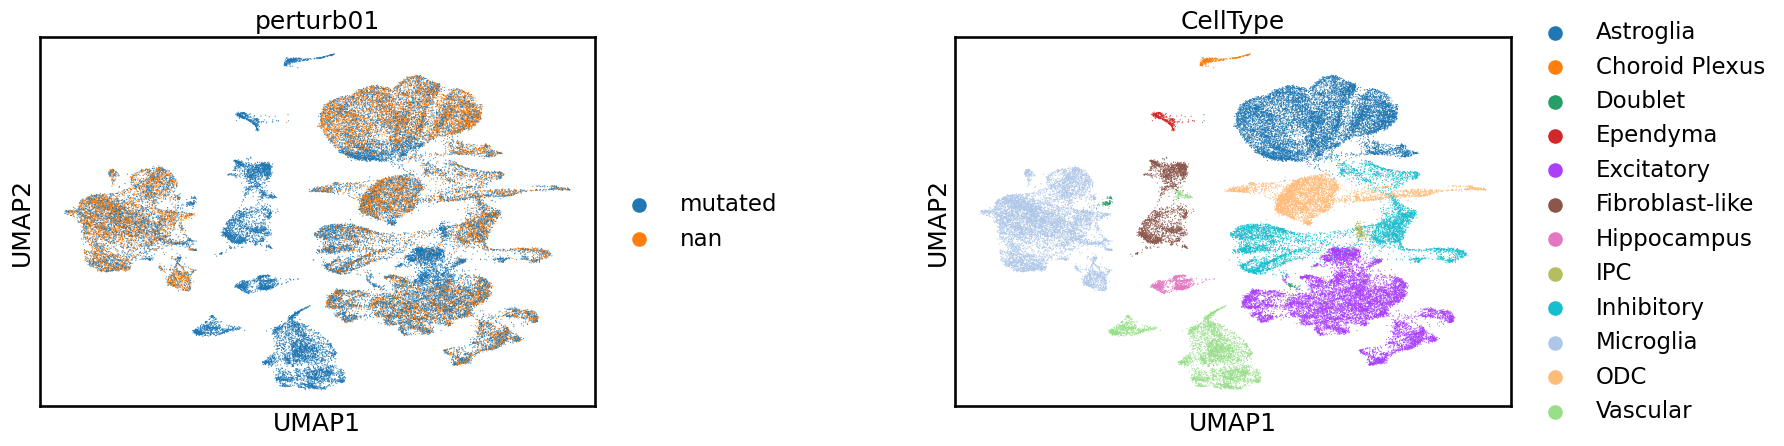

Cell cluster Choroid Plexus contains only one batch or has less than 10 cells. Skip.
Cell cluster Fibroblast-like contains only one batch or has less than 10 cells. Skip.
Cell cluster Vascular contains only one batch or has less than 10 cells. Skip.
Cell cluster Ependyma contains only one batch or has less than 10 cells. Skip.
Cell cluster IPC contains only one batch or has less than 10 cells. Skip.
Cell cluster Hippocampus contains only one batch or has less than 10 cells. Skip.
Cell cluster Doublet contains only one batch or has less than 10 cells. Skip.
LISI---


cLISI, bLISI, LISI_F1 0.9975858371049765 0.10355786565024833 0.18763738072517888


Variance contribution increased after integration!
Setting PCR comparison score to 0.
ASW---


asw_label 0.6389124840497971


asw_batch 0.8511181158068576


kBET---


7 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


kbet_score 0.366133644666235
graph_conn 0.9528391966613349


NMI, ARI ---
NMI 0.9172653404888367
ARI 0.8950500732128334
positive and true positive rate---


    ASW_label      ARI       NMI   1-cLISI     bLISI  ASW_batch  \
ef   0.638912  0.89505  0.917265  0.997586  0.103558   0.851118   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
ef          0.366134            0.952839          0  0.989504       0.210202   

     F1 LISI  
ef  0.187637  


In [7]:
adata=sc.read_h5ad("../data/ASD.h5ad")
run_mixscape(adata=adata, condition_key='perturb01', cell_type_key="CellType", exp_label='mutated', ref_label='nan', dataset_name="ASD")